# Generate COCO-formatted labels from geojsons and images

In [14]:
from coco_solaris.data import coco
import os
import numpy as np
import geopandas as gpd
from IPython.display import JSON
from matplotlib import pyplot as plt
from matplotlib import patches
import skimage

## Define Input and Output names
Make sure that both files, tif and json, are in same crs (e.g. here: "EPSG:3577")

In [2]:
inpath = "./testdata"
infname_tif = 'small_square_test.tif'
infname_json = 'small_test_3577.geojson'
fname_json = 'small_test_3577_poly.geojson'
outpath = "./converted_cocotest/"

os.makedirs(outpath, exist_ok=True)

### Convert MultiPolygons to Polygons (if needed)

In [3]:
df = gpd.read_file(os.path.join(inpath, infname_json))
df_exploded=df.explode(index_parts = False)
df_exploded.to_file(os.path.join(inpath, fname_json), driver='GeoJSON', 
index=False, crs=df.crs)

In [4]:
#inspect json dataframe
df_exploded.head()

,raster_val,sem_unc,ins_unc,area_ha,geometry
0,216.0,12.0,62.0,5.061789,"POLYGON ((1503076.303 -3852098.333, 1503091.97..."
1,229.0,2.0,39.0,23.158244,"POLYGON ((1503076.304 -3852218.852, 1503078.19..."
2,250.0,2.0,71.0,42.604965,"POLYGON ((1503927.782 -3852067.403, 1503924.65..."
3,255.0,2.0,38.0,22.858142,"POLYGON ((1503076.306 -3852730.539, 1503077.85..."
4,256.0,2.0,37.0,18.616492,"POLYGON ((1503865.392 -3852522.576, 1504118.04..."


### Generate COCO dictionary from image and json

In [5]:
coco_dict = coco.geojson2coco(
    os.path.join(inpath, infname_tif), 
    os.path.join(inpath,fname_json)
    )
    #,category_attribute='truncated')

  0%|          | 0/1 [00:00<?, ?it/s]/Users/seb/mambaforge/envs/coco_solaris/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 1/1 [00:00<00:00, 33.26it/s]


### Inspect new dictionary and plot generated COCO

In [12]:
# Display COCO image segmentation dict for the first entry
print(coco_dict['annotations'][0])

{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[-0.8927601689356379, -0.32084212760673836, 5.08859383885283, -0.32116677094018087, 4.773214007116621, 2.413358500110917, 1.6756346852052957, 3.072026832785923, -0.8927235625160392, 2.77783381100744, -0.8927601689356379, -0.32084212760673836]], 'area': 18.25798076396889, 'bbox': [-0.8927601689356379, -0.32116677094018087, 5.981354007788468, 3.393193603726104], 'iscrowd': 0}


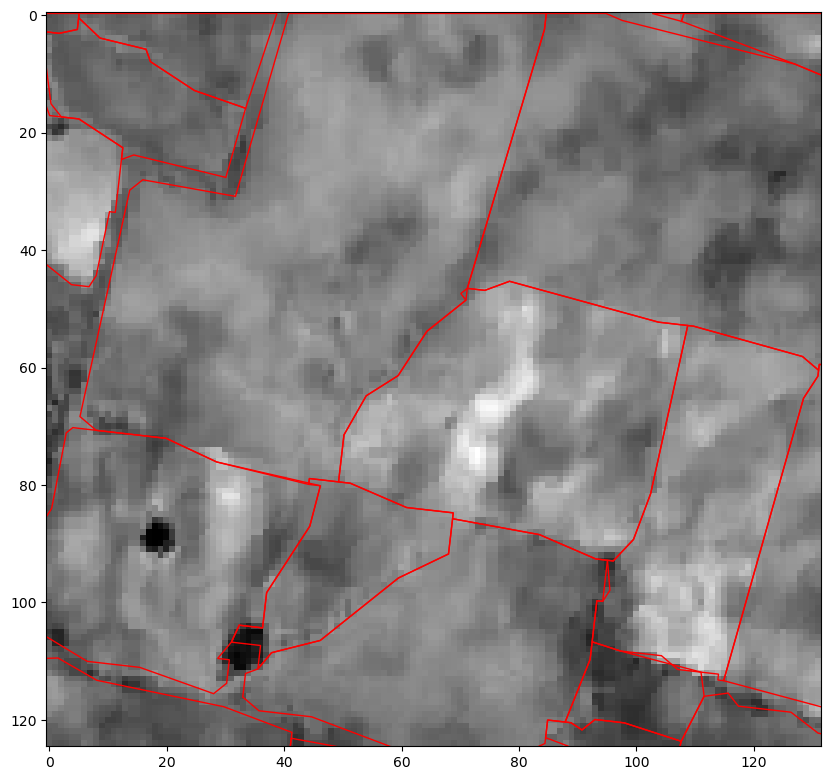

In [15]:
# Display COCO image segmentation
im = skimage.io.imread(os.path.join(inpath, infname_tif))
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap='gray')
colors = ['', 'r', 'b']
for anno in coco_dict['annotations']:
    poly = anno['segmentation'][0]
    poly = np.array(poly).reshape((int(len(poly)/2), 2))
    patch = patches.Polygon(poly, linewidth=1, edgecolor=colors[anno['category_id']], facecolor='none')
    #patch = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3], linewidth=1, edgecolor=colors[anno['category_id']], facecolor='none')
    ax.add_patch(patch)
plt.show()